# TO BE OR NOT TO BE INSURED? 
## How Social Networks Influence One's Decision To Insure

*Andrei Blahovici | Milena Kapralova | Luca Pantea | Paulius Skaisgiris*

This project is part of the Causality course at the UvA during fall 2023. We look at an experiment that investigated how the social environment of rice farmers in rural China influences whether they adopt weather insurance (Cai, De Janvry & Sadoulet, 2015), along with other variables such as demographics or previously adopting weather insurance.


TODO: make the image smaller using [rice.png](attachment:rice.png) or make it appear using
<img src=attachment:rice.png alt="drawing" width="200"/>

### Imports

In [1]:
# WARNING:
# The installation takes a few minutes.
# Only run during the first time running this notebook and if you don't have these packages installed.
# Run in terminal command line instead if it does not work.

# !pip install hyppo
# !pip install pingouin
# !pip install conditional_independence
# !pip install ipywidgets

In [38]:
import numpy as np
import pandas as pd
from itertools import permutations
import conditional_independence
import hyppo
import matplotlib.pyplot as plt
import networkx as nx
import pingouin as pg
import seaborn as sns
from sklearn import svm
from IPython.display import Image, display
from sklearn.linear_model import LinearRegression
from itertools import chain, combinations
from statsmodels.datasets import utils as du
from itertools import permutations
import itertools
import os

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
gld = Style.BRIGHT + Fore.YELLOW
grn = Style.BRIGHT + Fore.GREEN
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

# DoWhy
import dowhy
import dowhy.datasets
from dowhy import CausalModel
from dowhy.causal_identifier import backdoor

# Hide some warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.exceptions import DataConversionWarning

# Seed
np.random.seed(42)

# Configs
plt.rcParams['figure.figsize'] = [5, 5]

## 1 Introduction and Motivation




### Description of the Dataset
- **Paper introducing the dataset**: [Cai, Jing, Alain De Janvry, and Elisabeth Sadoulet. 2015. “Social Networks and the Decision to Insure.” ](https://www.aeaweb.org/articles?id=10.1257/app.20130442)
- **Data Source**: Data from a randomized experiment in rural China, focusing on weather insurance adoption among rice farmers. You can find the dataset in [this repository](https://github.com/NickCH-K/causaldata/tree/main/Python/causaldata/social-insure).
- **Observational Data**: Includes administrative records of insurance purchases and surveys on social networks, demographics, rice production, income, natural disasters, risk attitudes, and future disaster perceptions.
- **Interventional Data**: The experiment involved providing intensive information sessions about weather insurance to a subset of farmers, generating data on the impact of information dissemination through social networks on insurance uptake.
- **Collection Method**: Data collected through administrative records from the People's Insurance Company of China (PICC) and two surveys - a social network survey pre-experiment and a household survey post-insurance decision.

### Causal Questions Investigated
- **Primary Investigation**: Understanding the influence of social networks on the decision to purchase weather insurance.
- **Specific Questions**:
  1. Does providing intensive information to a subset of farmers increase insurance uptake among their social networks?
  2. Mechanisms of influence - is it through diffusion of insurance knowledge or observation of others' purchase decisions?

### Assumptions of the Dataset
- **Causal Sufficiency**: Assumes no unmeasured confounding variables affecting both network structure and insurance adoption.
- **No Cycles in the Causal Graph**: Assumes a linear progression from information dissemination to changes in insurance adoption, without feedback loops influencing initial information distribution.
- **Positivity**: Every farmer had a non-zero probability of being in both treatment and control conditions due to the randomized nature of the experiment.
- **SUTVA (Stable Unit Treatment Value Assumption)**: Assumes the treatment (information session) for one farmer does not directly affect another farmer's outcome not receiving the treatment, except through defined social networks.
- **Randomization**: Ensures unbiased estimates of treatment effects by randomly assigning farmers to different types of information sessions.

This study provides key insights into the role of social networks in economic decisions, especially in contexts with complex products like weather insurance in rural areas.





<!-- Introduce the datasets, the assumptions and the causal questions you are investigating.

• Describe your dataset (e.g. what are the observational data and how they were collected, in case there are interventional data, also what are they and how they were collected).

• Describe the causal questions you wish to answer (e.g. “we investigate the effect of X on Y”).

• Describe the assumptions of your dataset (causal sufficiency, no cycles in the causal graph, positivity, etc). -->

The following is a brief explanation of the dataset taken from [here](https://github.com/NickCH-K/causaldata/blob/main/Python/causaldata/social_insure/data.py):
- **Number of observations:** 1410
- **Number of variables** - 13
- Variable explanations:
    - *address* - Natural village
    - *village* - Administrative village
    - *takeup_survey* - Whether farmer ended up purchasing insurance. (1 = yes)
    - *age* - Household Characteristics - Age
    - *agpop* - Household Characteristics - Household Size
    - *ricearea_2010* - Area of Rice Production
    - *disaster_prob* - Perceived Probability of Disasters Next Year
    - *male* - Household Caracteristics: Gender of Household Head (1 = male)
    - *default* - "Default option" in experimental format assigned to. (1 = default is to buy, 0 = default is to not buy)
    - *intensive* - Whether or not was assigned to "intensive" experimental session (1 = yes)
    - *risk_averse* - Risk aversion measurement
    - *literacy* - 1 = literate, 0 = illiterate
    - *pre_takeup_rate* - Takeup rate prior to experiment

### Removing variables for causal analysis

After reading the dataset's paper, we chose not to adopt the authors' approach, as it focused on the impact of the effect of social networks on the `takeup_survey` variable. We did not learn sufficient tools in the course to suitably tackle such questions. Additionally, the dataset's 13 variables were excessive. Therefore, we decided to eliminate some features and conduct a causal analysis on the remaining ones using methods learned in class. The following is a list discussing the case of (not) keeping each variable:
- *address* - **do not keep**: geographical feature, relevant only for the social network analysis.
- *village* - **do not keep**: geographical feature, relevant only for the social network analysis.
- *takeup_survey* - **keep**: control variable.
- *age* - **keep**: we hypothesize that the person's experience is a strong feature that may impact other variables such as whether to buy insurance.
- *agpop* - **keep**: we think a household size may affect the person's decision to get insurance.
- *ricearea_2010* - **keep**: this seems to be a variable representing some kind of financial situation of the household, seems reasonable to be relevant for whether insurance is bought
- *disaster_prob* - **do not keep**: Because we decide to keep `risk_averse` instead which seems very similar. Quote from the dataset's paper: "The perceived probability of future disasters was elicited by asking, "What do you think is the probability of a disaster that leads to more than 30% loss in yield next year?".
- *male* - **do not keep**: we see no reason why gender may affect purchasing insurance.
- *default* - **do not keep**: very similar to `pre_takeup_rate`.
- *intensive* - **do not keep**: feature relevant only for the social network analysis.
- *risk_averse* - **keep**: Similar feature to `disaster_prob`. Quote from the dataset's paper: "Risk attitudes were elicited by asking households to choose between a certain amount with increasing values of 50, 80, 100, 120, and 150 RMB (riskless option A), and risky gambles of (200RMB, 0) with probability (0.5, 0.5) (risky option B). The proportion of riskless options chosen was then used as a measure of risk aversion, which ranges from 0 to 1."
- *literacy* - **keep**: a feature loosely indicating the education level of an individual. May be interesting to investigate how literacy contributes to buying insurance - a somewhat abstract promise for a future safety in case of disaster.
- *pre_takeup_rate* - **keep**: we expect this feature to have a large effect on `takeup_survey`.

In [39]:
data = du.load_csv("rice-insurance-causality", os.path.join("data", "Cai_2015.csv"), sep=",")
data = du.strip_column_names(data)

In [40]:
data.head()

,address,village,takeup_survey,age,agpop,ricearea_2010,disaster_prob,male,default,intensive,risk_averse,literacy,pre_takeup_rate
0,beilian2,beilian,0,62.0,2.0,10.0,30.0,1.0,1,0,0.0,0.0,0.071429
1,beilian2,beilian,1,63.0,5.0,15.0,100.0,1.0,1,0,0.0,1.0,0.071429
2,beilian2,beilian,1,44.0,3.0,7.5,20.0,1.0,1,1,0.0,1.0,0.071429
3,beilian2,beilian,1,76.0,6.0,NaN,50.0,1.0,1,1,0.6,1.0,0.071429
4,beilian2,beilian,0,52.0,6.0,11.0,0.0,1.0,1,1,0.2,1.0,0.071429


In [41]:
control_variables = ["age", "agpop", "ricearea_2010", "risk_averse", "literacy", "pre_takeup_rate"]
dependent_variables = ["takeup_survey"]

data = data.drop(data.columns.difference(control_variables + dependent_variables), 1)

## 2 Exploratory Data Analysis

As shown in Tutorial 2. 

• Testing correlation / dependence for the variables in the dataset and show how they are dependent.

• Discuss the true causal graph of the dataset, if it’s known, and otherwise discuss a reasonable guess.


**Note form the 5th tutorial:
If we see that our relationships between variables is nonlinear, we can try to transform them to become linear. Alternatively, we could use nonparametric tests for dependence (as opposed to the naive, linear gaussian tests) but they require more data (maybe we could try them with 500 samples)**

In [42]:
print(f'{blk}Shapes: {red}{data.shape}')

print(f'{blk}Any missing values: {red}{data.isna().any().any()}')

Shapes: (1410, 7)
Any missing values: True


In [43]:
missing = data.isna().sum().reset_index()
missing.columns = ['columns', 'missing_count']

print(f'{blk}Missing values:'
      f'\n\n{red}{missing[missing.missing_count > 0]}{res}')

Missing values:

         columns  missing_count
1            age              4
2          agpop              6
3  ricearea_2010              9
5       literacy             21


In [44]:
data = data.dropna(axis=0, how="any")

In [52]:
data.describe()

,takeup_survey,age,agpop,ricearea_2010,risk_averse,literacy,pre_takeup_rate
count,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000
mean,0.460870,51.401449,4.892029,13.487116,0.174493,0.794203,0.429572
std,0.498647,12.075950,2.072107,22.020053,0.305879,0.404429,0.240963
min,0.000000,18.000000,1.000000,0.400000,0.000000,0.000000,0.000000
25%,0.000000,42.000000,4.000000,5.000000,0.000000,1.000000,0.222222
50%,0.000000,50.000000,5.000000,10.000000,0.000000,1.000000,0.421053
75%,1.000000,60.000000,6.000000,16.000000,0.200000,1.000000,0.564732
max,1.000000,85.000000,19.000000,650.000000,1.000000,1.000000,1.000000


In [49]:
cm = sns.light_palette('#b51800', as_cmap=True)

counts = pd.Series({ft: [data[ft].value_counts().round(3).iloc[:5].to_dict()] for ft in data.columns}, name='top_5_counts')
nunique = data.nunique().rename('nunique')

min_max = data.describe().T[['min', 'max']]
stats_pivot = pd.concat([min_max, nunique, counts], axis=1)
display(stats_pivot)

,min,max,nunique,top_5_counts
takeup_survey,0.0,1.0,2,"[{0: 744, 1: 636}]"
age,18.0,85.0,67,"[{40.0: 61, 45.0: 57, 42.0: 52, 43.0: 50, 41.0..."
agpop,1.0,19.0,16,"[{4.0: 415, 5.0: 286, 6.0: 206, 2.0: 124, 3.0:..."
ricearea_2010,0.4,650.0,166,"[{10.0: 128, 12.0: 81, 5.0: 79, 20.0: 70, 4.0:..."
risk_averse,0.0,1.0,6,"[{0.0: 953, 0.39999998: 119, 0.19999999: 95, 1..."
literacy,0.0,1.0,2,"[{1.0: 1096, 0.0: 284}]"
pre_takeup_rate,0.0,1.0,76,"[{0.5: 90, 0.33333334: 48, 0.25: 48, 0.1428571..."


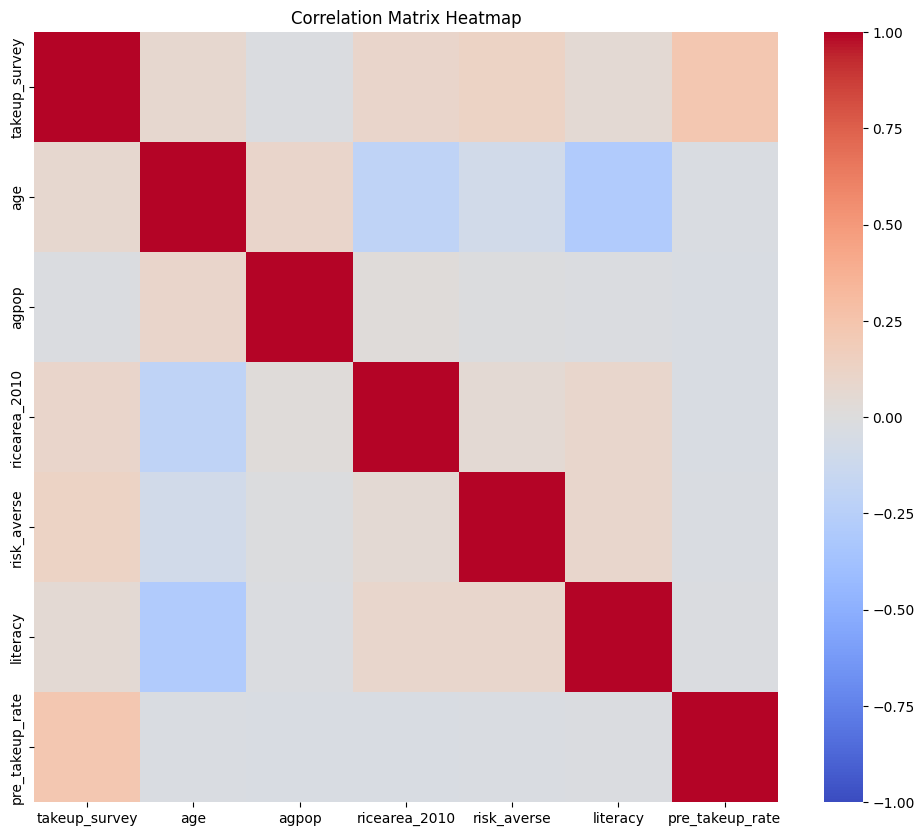

In [45]:
# Compute the correlation matrix
corr_matrix = data.corr()

# Plotting the heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [46]:
# Identifying pairs of highly correlated variables
corr_threshold = 0.05

# Creating a DataFrame to hold pairs of highly correlated variables
high_corr_pairs = pd.DataFrame(columns=['Variable 1', 'Variable 2', 'Correlation'])

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            high_corr_pairs = high_corr_pairs.append({
                'Variable 1': corr_matrix.columns[i],
                'Variable 2': corr_matrix.index[j],
                'Correlation': corr_matrix.iloc[i, j]
            }, ignore_index=True)

display(high_corr_pairs.sort_values(by='Correlation', ascending=False).reset_index(drop=True), f'Correlation for threshold {corr_threshold}')

,Variable 1,Variable 2,Correlation
0,pre_takeup_rate,takeup_survey,0.231672
1,risk_averse,takeup_survey,0.129426
2,agpop,age,0.095977
3,ricearea_2010,takeup_survey,0.095486
4,literacy,risk_averse,0.086499
5,literacy,ricearea_2010,0.086148
6,age,takeup_survey,0.073783
7,risk_averse,age,-0.089967
8,ricearea_2010,age,-0.207554
9,literacy,age,-0.294882


'Correlation for threshold 0.05'

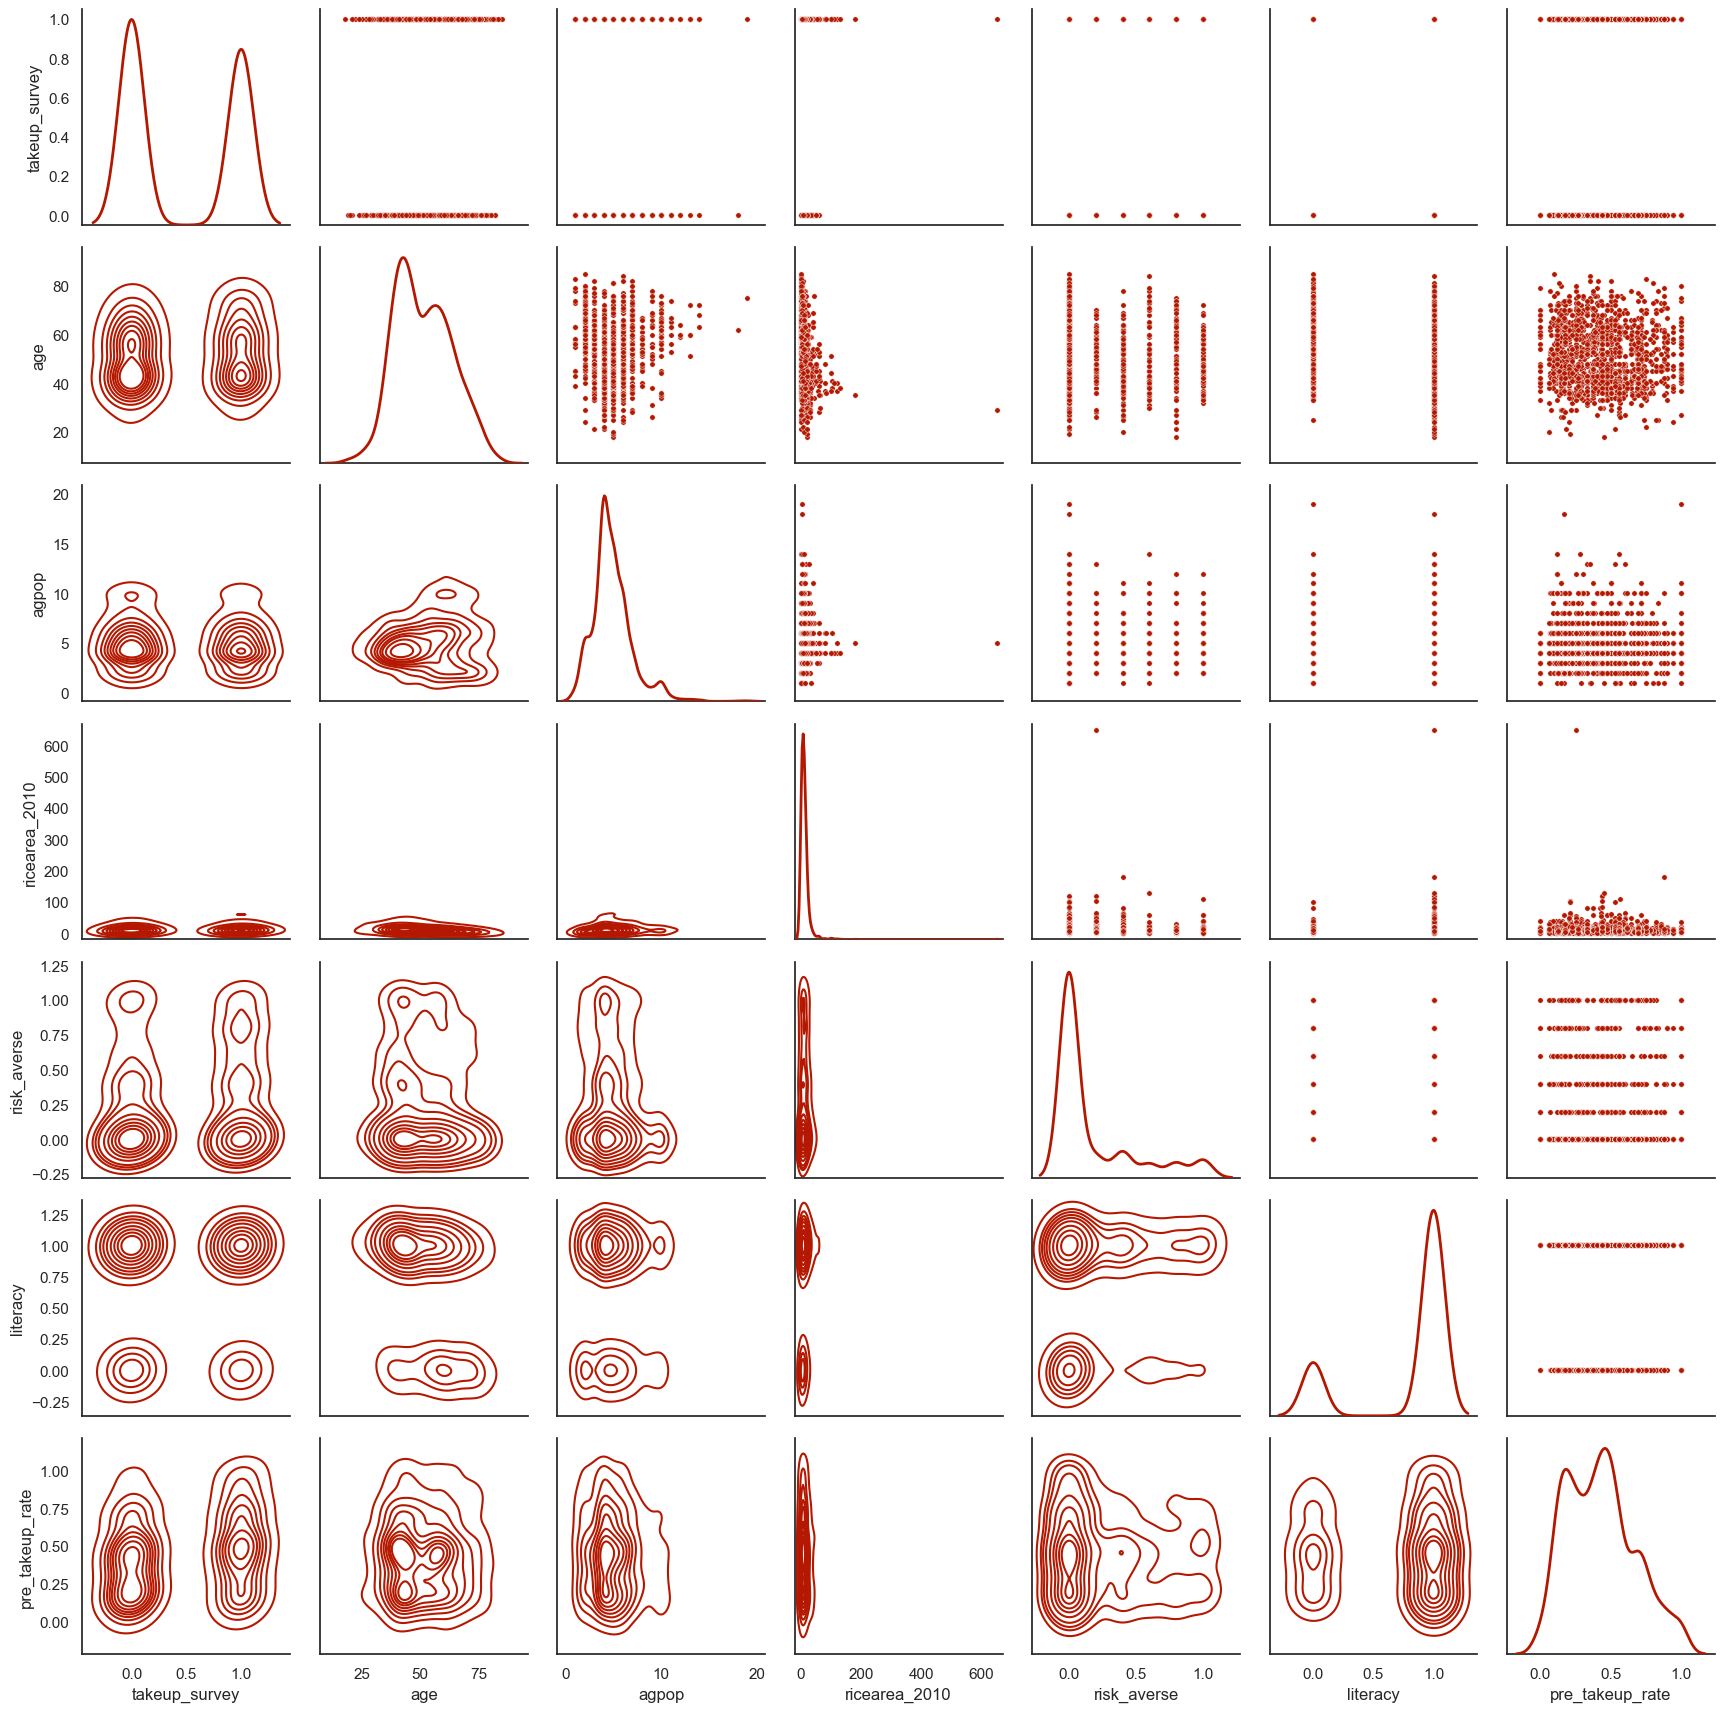

In [47]:
# Paired denisty and scatter plot for observing the relationships between our variables
sns.set_theme(style="white")

g = sns.PairGrid(data, diag_sharey=False)
g.map_upper(sns.scatterplot, s=15, color='#b51800')
g.map_lower(sns.kdeplot, color='#b51800')
g.map_diag(sns.kdeplot, lw=2, color='#b51800')

In [13]:
class ExplorationManager:
    '''
    Takes care of exploratory analyses, including d-separation, visualisation and testing for independences.
    '''
    def __init__(self, data, G=None):
        '''
        :param data: data (df)
        :param G: the graph (a DiGraph object)
        '''
        self.data = data
        self.G = G
        
    def is_d_separated(self, x, y, z):
        '''
        Verifies whether two (sets of) variables are d-separated by a (set) of variables.
        
        :param x: a set of independent variable(s), len(x) > 0
        :param y: a set of dependent variable(s), len(y) > 0
        :param z: a set of conditioning variables, len(z) >= 0
        '''
        return nx.algorithms.d_separated(G=self.G, x=x, y=y, z=z)

    def visualize_rel(self, x, y):
        '''
        Visualizes the relationship between x and y.

        :param x: the independent variable
        :param y: the dependent variable
        '''
        plt.scatter(self.data[x], self.data[y])
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(f'Data distribution of {x} and {y}')
        plt.show()
    
    def is_dependent(self, x, y, z=[]):
        '''
        Tests  whether two variables are dependent. 
        By default tests for marginal dependence, if z (conditioning set) 
        is specified, tests for conditional dependence.
        
        :param x: an independent variable (str)
        :param y: a dependent variable (str)
        :param z: conditioning set (list)
        
        Returns n, r, 95% CI and a p-value (df).
        '''
        return pg.partial_corr(data=self.data, x=x, y=y, covar=z, method='pearson')

    def is_marginally_dependent(self, x, y):
        '''
        Tests  whether two variables are marginally dependent. 
        
        :param x: an independent variable (list/array)
        :param y: a dependent variable (list/array)
        
        Returns n, r, 95% CI and a p-value, BF10 and power (df).
        '''
        return pg.corr(x=x, y=y, method='pearson')
    
    def is_hsic_dependent(self, x, y):
        '''
        Tests the dependece of two variables using the Hilbert Schmidt Independence Criterion.
        
        :param x: an independent variable (list/array)
        :param y: a dependent variable (list/array)
        
        Returns the hsic statistic and p-value (tuple).
        '''
        hsic, p = hyppo.independence.Hsic().test(self.data[x], self.data[y])
        return hsic, p
    
    def test_all(self, variables, method='marginal'):
        '''
        Tests dependence of all possible permutations of variables specified.
        By default tests for marginal dependence, if the method variable is changed,
        tests for conditional dependence.
        
        :param variables: all variables to consider (list)
        :param method: {'marginal', 'conditional', 'both'}
        
        Returns a dictionary of p-values.
        '''
        dependence_tests = {}
        
        if method in ['marginal', 'both']:
            for var1, var2 in permutations(variables, 2):
                dependence_tests[var1, var2] = pg.partial_corr(data=self.data, x=var1, y=var2, covar=[], method='pearson')['p-val'].item()
                
        if method in ['conditional', 'both']:
            for var1, var2, cond in permutations(variables, 3):
                 dependence_tests[var1, var2, cond] = pg.partial_corr(data=self.data, x=var1, y=var2, covar=[cond], method='pearson')['p-val'].item()
        
        return dependence_tests
    
    def test_all_hsic(self, variables, method="marginal"):
        '''
        Tests dependence of all possible permutations of variables specified using HSIC.
        
        :param variables: all variables to consider (list)
        
        Returns a dictionary of p-values.
        '''
        dependence_tests = {}

        if method in ["marginal", "both"]:
            for var1, var2 in permutations(variables, 2):
                dependence_tests[var1, var2] = conditional_independence.hsic_test(np.stack((self.data[var1], self.data[var2]), axis=1), i=0, j=1, cond_set=[])["p_value"]
        
        if method in ["conditional", "both"]:
            for var1, var2, cond in permutations(variables, 3):
                dependence_tests[var1, var2, cond] = conditional_independence.hsic_test(np.stack((self.data[var1], self.data[var2], self.data[cond]), axis=1), i=0, j=2, cond_set=[2])["p_value"]
                
        return dependence_tests

exploration_manager = ExplorationManager(data)

### (Conditional) independence tests

In [6]:
import warnings
warnings.filterwarnings("ignore")

dependency_tests = exploration_manager.test_all_hsic(control_variables + dependent_variables, method="marginal")
dependency_tests_cond = exploration_manager.test_all_hsic(control_variables + dependent_variables, method="conditional")

In [7]:
# Independence tests

alpha = 0.05
# Remove NaNs as it's unclear how to deal with them (re-running the tests doesn't really work sometimes)
dependency_tests = {k: v for k, v in dependency_tests.items() if not np.isnan(v)}

# > alpha => independent
for (var1, var2), v in dependency_tests.items():
    if v > alpha:
        print(var1, "NOT dep", var2)
    else:
        print(var1, "dep", var2)

age dep agpop
age dep ricearea_2010
age NOT dep risk_averse
age dep literacy
age NOT dep pre_takeup_rate
age NOT dep takeup_survey
agpop dep age
agpop dep ricearea_2010
agpop NOT dep risk_averse
agpop dep literacy
agpop NOT dep pre_takeup_rate
agpop NOT dep takeup_survey
ricearea_2010 dep age
ricearea_2010 dep agpop
ricearea_2010 dep risk_averse
ricearea_2010 dep literacy
ricearea_2010 NOT dep pre_takeup_rate
ricearea_2010 dep takeup_survey
risk_averse NOT dep age
risk_averse NOT dep agpop
risk_averse dep ricearea_2010
risk_averse dep literacy
risk_averse NOT dep pre_takeup_rate
risk_averse dep takeup_survey
literacy dep age
literacy dep agpop
literacy dep ricearea_2010
literacy dep risk_averse
literacy NOT dep pre_takeup_rate
literacy NOT dep takeup_survey
pre_takeup_rate NOT dep age
pre_takeup_rate NOT dep agpop
pre_takeup_rate NOT dep ricearea_2010
pre_takeup_rate NOT dep risk_averse
pre_takeup_rate NOT dep literacy
pre_takeup_rate dep takeup_survey
takeup_survey NOT dep age
takeup_

In [8]:
# Conditional indpendence tests

# Remove NaNs as it's unclear how to deal with them (re-running the tests doesn't really work sometimes)
dependency_tests_cond = {k: v for k, v in dependency_tests_cond.items() if not np.isnan(v)}

# > alpha => independent
seen = {}
for (var1, var2, cond), v in dependency_tests_cond.items():
    if v > alpha and (var1, var2) in dependency_tests and dependency_tests[var1, var2] <= alpha and ((var1, var2, cond) not in seen and (var2, var1, cond) not in seen):
        print(var1, "NOT dep", var2, "|", cond)

    if v <= alpha and (var1, var2) in dependency_tests and dependency_tests[var1, var2] <= alpha and ((var1, var2, cond) not in seen and (var2, var1, cond) not in seen):
        print(var1, "dep", var2, "|", cond)

    seen[var1, var2, cond] = True

age NOT dep agpop | ricearea_2010
age NOT dep ricearea_2010 | agpop
age NOT dep literacy | agpop
age NOT dep literacy | ricearea_2010
agpop NOT dep age | literacy
agpop dep ricearea_2010 | age
agpop NOT dep ricearea_2010 | literacy
agpop dep literacy | age
agpop NOT dep literacy | ricearea_2010
ricearea_2010 NOT dep age | risk_averse
ricearea_2010 NOT dep agpop | risk_averse
ricearea_2010 dep risk_averse | age
ricearea_2010 NOT dep risk_averse | agpop
ricearea_2010 dep literacy | age
ricearea_2010 NOT dep literacy | agpop
ricearea_2010 NOT dep literacy | risk_averse
ricearea_2010 dep takeup_survey | age
ricearea_2010 NOT dep takeup_survey | agpop
ricearea_2010 NOT dep takeup_survey | risk_averse
risk_averse NOT dep ricearea_2010 | literacy
risk_averse NOT dep literacy | age
risk_averse NOT dep literacy | ricearea_2010
risk_averse NOT dep takeup_survey | age
risk_averse NOT dep takeup_survey | ricearea_2010
risk_averse NOT dep takeup_survey | literacy
literacy NOT dep age | risk_averse


Solely given the (conditional) independence tests above, we arrive at the following graph (dependent variable with double circles):
![graph-before-common-sense](graph-before-common-sense.png)

$\newcommand{\indep}{\perp \!\!\! \perp}$

We started by looking at the result of independence tests of pairs of features giving us the initial arrows. We then investigated conditional dependences and shifted some arrows around in order to fit the result of conditional tests. For example, from the conditional tests we see that $$\text{agpop} \indep \text{ricearea\_2010} \ | \  \text{age}$$

and indeed `age` is a confounder for `agpop` and `ricearea_2010`. We also see that

$$\text{agpop} \indep \text{literacy} \ | \  \text{age}$$

and, again, `age` is a confounder for `agpop` and `literacy`. As a last example, we see that

$$\text{ricearea\_2010} \indep \text{takeup\_survey} \ | \  \text{age}$$

which means that ...

# TODO: why does the last one hold?

The (conditional) independence tests can only get us so far. We hypothesize that the `pre_takeup_rate` must be influenced by other features as well and we thus apply common sense to slightly modify our estimated causal graph. Particularly, we think `age` can impact `pre_takeup_rate` as more experience, potentially with other insurances in the past, might lead a person to buy one. Second, `literacy` reflects education of an individual and so we think that likely it may affect `pre_takeup_rate` as well. Lastly, `risk_averse` variable is a measure of how risk-prone the individual is, thus we think it may impact the individual's predisposition to buying insurance (e.g. if the individual is risk averse, they may be more likely to buy insurance). We draw an arrow from the afore-mentioned features to `pre_takeup_rate`.

The final causal graph is thus:
![graph-after-common-sense](graph-after-common-sense.png)

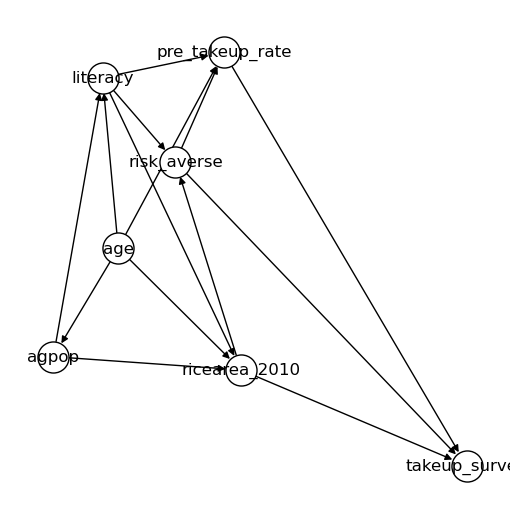

In [9]:
# Convert the above graph into networkx
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(control_variables + dependent_variables)
G.add_edges_from([('age','literacy'),
                  ('age','agpop'), 
                  ('age','ricearea_2010'), 
                  ('age','pre_takeup_rate'), 
                  ('ricearea_2010','risk_averse'), 
                  ('ricearea_2010','takeup_survey'), 
                  ('agpop','literacy'),
                  ('agpop','ricearea_2010'), 
                  ('literacy','ricearea_2010'), 
                  ('literacy','risk_averse'),
                  ('literacy','pre_takeup_rate'),
                  ('risk_averse','takeup_survey'),
                  ('risk_averse','pre_takeup_rate'),
                  ('pre_takeup_rate','takeup_survey')])

nx.draw(G, with_labels=True, node_size=500, node_color='w', edgecolors ='black')
nx.write_gml(G, "estimated_social_insurance_graph.gml")

## 3 Identifying Estimands

As shown in Tutorials 3 and 4. Identify possible adjustment sets by hand by using:

• Backdoor criterion (most important)

• Frontdoor criterion

• Instrumental variables

Report what happens for these methods even if they don’t apply and explain why. Also show the results you get for each of these estimands from doWhy and compare with the ones you found by hand.

### Backdoor criterion

In [10]:
class BackdoorManager:
    """Class that groups functions for computing backdoor criterion of a causal graph."""

    def __init__(self, G, node_x, node_y):
        '''
        :param G: graph (a DiGraph object)
        :param node_x: a node whose effect we are trying to predict
        :param node_y: a node effect on which we are trying to predict
        '''
        self.G = G
        self.node_x = node_x
        self.node_y = node_y
        self.descendants_node_x = nx.descendants(self.G, node_x) | {node_x}
        
    def draw(self, pos, edge_color='black'):
        """Draws the graph given a certain position and color of the nodes."""
        nx.draw(self.G, pos=pos, with_labels=True, node_size=500, node_color='w', edgecolors='black', edge_color=edge_color)
        
    def write_gml(self, fname='backdoor_criterion_graph.gml'):
        nx.write_gml(G, fname)
        
    def get_all_paths(self):
        H = self.G.to_undirected()
        all_paths = list(nx.all_simple_paths(H, self.node_x, self.node_y))
        return all_paths
    
    def get_backdoor_paths(self):
        bd = backdoor.Backdoor(self.G, self.node_x, self.node_y)
        all_paths = self.get_all_paths()
        backdoor_paths = [path for path in all_paths if bd.is_backdoor(path)]
        return backdoor_paths
        
    def give_coll_noncoll_on_(self, path):
        """Finds all colliders and non-colliders on a path."""
        colliders = np.array([])
        non_colliders = []
        path_len = len(path)
        
        # Collider
        ## Loop through adjacent variables on the path, ignore the source and target variables as potential colliders
        for node0, node1, node2 in zip(path[0:path_len-2], path[1:path_len-1], path[2:]):
            if self.G.has_edge(node0, node1) and self.G.has_edge(node2, node1):
                ## Add the collider (and all its descendants) to the list
                colliders = np.append(colliders, list(nx.descendants(self.G,node1)) + [node1])
        colliders = colliders.flatten()
        
        # Non-collider
        non_colliders = [x for x in path[1:-1] if x not in colliders]

        return colliders, non_colliders
    
    def find_adjustment_variables(self):
        """Performs the backdoor criterion search."""

        self.adjustment_variables = pd.DataFrame(columns=['path', 'colliders', 'non_colliders'])
        paths = self.get_backdoor_paths()
        
        for path in paths:
            colliders, non_colliders = self.give_coll_noncoll_on_(path)
            self.adjustment_variables.loc[len(self.adjustment_variables.index)] = [path, colliders, non_colliders]
    
    def find_adjustment_sets(self, method='default'):
        """
        Finds backdoor adjustment sets based on the adjustment variables and method. 
        Default method finds all the minimum-sized and maximum-sized adjustment sets, 
        
        :param method_name: {'default', 'exhaustive-search', 'minimal-adjustment', 'maximal-adjustment', 
                             'efficient-adjustment', 'efficient-minimal-adjustment', 'efficient-mincost-adjustment'}
        """
        self.find_adjustment_variables()
        colliders = set()
        non_colliders = set()
        
        for index, row in self.adjustment_variables.iterrows():
            colliders.update(row['colliders'])
            non_colliders.update(row['non_colliders'])
        
        # Remove X and Y from the set of nodes that we can condition on
        for terminal in [self.node_x, self.node_y]:
            if terminal in colliders:
                colliders.remove(terminal)
            if terminal in non_colliders:
                non_colliders.remove(terminal)      
            
        candidate_vars = colliders.union(non_colliders)
        
        all_combinations = list(chain.from_iterable(combinations(candidate_vars, r) for r in range(len(candidate_vars)+1)))
        
        # Checking which of the combinations are valid backdoor adjustment sets
        self.adjustment_sets = []
        for candidate_combination in all_combinations:
            valid = True
            candidate_combination = set(candidate_combination)
            for index, row in self.adjustment_variables.iterrows():
                current_colliders = set(row['colliders'])
                current_non_colliders = set(row['non_colliders'])
                
                # Conditions
                cond1 = len(current_colliders.intersection(candidate_combination)) == 0
                cond2 = len(current_non_colliders.intersection(candidate_combination)) > 0 
                cond3 = len(candidate_combination.difference(non_colliders)) == 0
                if len(current_colliders) == 0:
                    combined_cond = cond2
                elif len(current_non_colliders) == 0:
                    combined_cond = cond1
                else:
                    combined_cond = cond1 or cond2

                # Evaluate whether the candidate combination of adjustment variables meets the conditions
                if not combined_cond or (not cond3):
                    valid = False
                    
            if valid:
                self.adjustment_sets.append(candidate_combination)
        
        return self.adjustment_sets

In [11]:
def gml_to_string(path):
    """A utility function to parse the .gml file to string"""

    gml_str = ''
    with open(path, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

In [12]:
for control in control_variables:
    print(f"=== {control} === ")

    # Compute backdoor adjustment sets "by hand"
    back_mgr = BackdoorManager(G, control, dependent_variables[0])
    adjustment_sets = back_mgr.find_adjustment_sets()
    print(f"Manual adjustment sets: {adjustment_sets}")

    # Compute the same thing automatically using DoWhy
    gml_graph = gml_to_string('estimated_social_insurance_graph.gml')
    model = CausalModel(data=data,
                        treatment=control,
                        outcome=dependent_variables[0],
                        graph=gml_graph)
    dowhy_adj_sets = model.identify_effect().backdoor_variables

    # Take only unique backdoor adjustment sets
    # dowhy_adj_sets = np.unique(list(dowhy_adj_sets.values()))
    print(f"Dowhy adjustment sets: {dowhy_adj_sets}")

    dowhy_adj_sets = [set(x) for x in dowhy_adj_sets.values()]

    in_manual = []
    for x in dowhy_adj_sets:
        in_manual.append(x in adjustment_sets)
    print(f"DoWhy adj set in manual?", in_manual)
    print()

=== age === 
Manual adjustment sets: [set()]
Dowhy adjustment sets: {'backdoor1': [], 'backdoor': []}
DoWhy adj set in manual? [True, True]

=== agpop === 
Manual adjustment sets: [{'age'}, {'age', 'risk_averse'}, {'age', 'pre_takeup_rate'}, {'age', 'ricearea_2010'}, {'age', 'literacy'}, {'age', 'pre_takeup_rate', 'risk_averse'}, {'age', 'risk_averse', 'ricearea_2010'}, {'age', 'risk_averse', 'literacy'}, {'age', 'pre_takeup_rate', 'ricearea_2010'}, {'age', 'pre_takeup_rate', 'literacy'}, {'age', 'ricearea_2010', 'literacy'}, {'age', 'pre_takeup_rate', 'risk_averse', 'ricearea_2010'}, {'age', 'pre_takeup_rate', 'risk_averse', 'literacy'}, {'age', 'risk_averse', 'literacy', 'ricearea_2010'}, {'pre_takeup_rate', 'risk_averse', 'literacy', 'ricearea_2010'}, {'age', 'pre_takeup_rate', 'literacy', 'ricearea_2010'}, {'risk_averse', 'age', 'pre_takeup_rate', 'ricearea_2010', 'literacy'}]
Dowhy adjustment sets: {'backdoor1': ['age'], 'backdoor2': ['age'], 'backdoor': ['age']}
DoWhy adj set in 

### Frontdoor criterion

In [13]:
class FrontdoorManager:
    '''
    This class takes care of the frontdoor adjustment using DoWhy.
    '''
    def __init__(self, data, treatment, outcome, graph_path='estimated_graph.gml'):
        '''
        :param data: the data we are investigating (pandas DataFrame)
        :param treatment: name of the treatment variable (str)
        :param outcome: name of the outcome variable (str)
        :param graph_path: path to the networkx graph's .gml file
        '''
        self.graph_str = self.gml_to_string(graph_path)
        self.node_x = treatment
        self.node_y = outcome
        self.model = CausalModel(data=data,
                                 treatment=treatment,
                                 outcome=outcome,
                                 graph=self.graph_str)
        self.graph = self.model._graph

    def draw(self):
        self.model.view_model()
        
    def gml_to_string(self, graph_path):
        '''Utility function to parse the .gml file to string

        :param graph_path: the path to the .gml file
        
        Returns the gml graph as a string.
        '''
        gml_str = ''
        with open(graph_path, 'r') as file:
            for line in file:
                gml_str += line.rstrip()
        return gml_str

    def are_paths_blocked(self, paths):
        """Computes whether each path is blocked.

        :param paths: list of paths to check

        Returns a list of booleans indicating whether each element in the input
        parameter `paths` is blocked
        """

        # list for keeping track of which paths are blocked
        is_path_blocked = []

        # looping through the paths from node_x to node_y
        for path in paths:
            # the is_blocked function checks with a path is blocked when conditioning on the set conditioned_nodes
            # in this case, we are not conditioning on any nodes, so give it the empty set
            is_path_blocked.append(self.graph.is_blocked(path, conditioned_nodes = []))

        return is_path_blocked

    def get_directed_adjustment_sets(self, debug=True):
        """Compute directed adjustment sets for frontdoor criterion.

        Returns a list of adjustment sets.
        """
        # Find all directed paths between node_x and node_y
        # directed_paths = self.graph.get_all_directed_paths(self.node_x, self.node_y)
        directed_paths = list(nx.all_simple_paths(front_mgr.graph._graph, self.node_x, self.node_y))
        directed_paths = np.array(directed_paths)

        # Compute whether they are blocked
        is_blocked = self.are_paths_blocked(directed_paths)
        if debug:
            print("Pre-filter", directed_paths)

        # Filter out all paths that are not blocked
        directed_paths = directed_paths[np.where(is_blocked == True)[0]]
        if debug:
            print("Post-filter", directed_paths)

        # Drop the first and last element as the adjustment set 
        # does not involve starting and ending nodes
        directed_adj_sets = [path[1:-1] for path in directed_paths]
        return directed_adj_sets

    def find_adjustment_sets(self, debug=True): 
        """Finds adjustment sets satisfying the frondoor criterion."""
        
        # Set M satisfies the frontdoor criterion if all three hold:

        # 1. M Blocks all directed paths from node_x to node_y
        M = self.get_directed_adjustment_sets(debug)

        # 2. No unblocked backdoor paths from node_x to any node in M
        
        M_post2 = []
        # For each directed adjustment set...
        for adj_set in M:
            all_blocked = True

            # For each node in the directed adjustment set...
            for node in adj_set:
                # Compute all backdoor paths from node_x to node
                back_paths = self.graph.get_backdoor_paths(node_x, node)
                # Compute whether all backdoor paths are blocked
                if not np.all(self.are_paths_blocked(back_paths)):
                    all_blocked = False

            # If all backdoor paths are blocked, then it is passes the second point
            # and is a possible adjustment set
            if all_blocked:
                M_post2.append(adj_set)

        # 3. No unblocked backdoor paths from any node in M to node_y

        M_post3 = []
        # For each directed adjustment set...
        for adj_set in M_post2:
            all_blocked = True

            # For each node in the directed adjustment set...
            for node in adj_set:
                # Compute all backdoor paths from node to node_y
                back_paths = self.graph.get_backdoor_paths(node, node_y)
                # Compute whether all backdoor paths are blocked
                if not np.all(self.are_paths_blocked(back_paths)):
                    all_blocked = False

            # If all backdoor paths are blocked, then it is passes the third point
            # and is a possible adjustment set
            if all_blocked:
                M_post3.append(adj_set)
        
        return M_post3

In [14]:
for control in control_variables:
    print(f"=== {control} === ")

    # Initialize manager which holds a plethora of handy methods for frontdoor
    front_mgr = FrontdoorManager(data=data, 
                                 treatment=control, 
                                 outcome=dependent_variables[0], 
                                 graph_path="estimated_social_insurance_graph.gml")
    
    adjustment_sets = front_mgr.find_adjustment_sets(debug=False)
    print(f"Manual adjustment sets: {adjustment_sets}")

    # Estimate frondoor adjustment sets automatically using dowhy
    dowhy_adj_sets = front_mgr.model.identify_effect().frontdoor_variables
    print(f"DoWhy adjustment sets: {dowhy_adj_sets}")
    
    if len(dowhy_adj_sets) == 0:
        in_manual = "True" if len(adjustment_sets) == 0 else "False"
    else:
        dowhy_adj_sets = [set(x) for x in dowhy_adj_sets.values()]

        in_manual = []
        for x in dowhy_adj_sets:
            in_manual.append(x in adjustment_sets)
    print(f"DoWhy adj set in manual?", in_manual)

    print()

=== age === 
Manual adjustment sets: []
DoWhy adjustment sets: []
DoWhy adj set in manual? True

=== agpop === 
Manual adjustment sets: []
DoWhy adjustment sets: []
DoWhy adj set in manual? True

=== ricearea_2010 === 
Manual adjustment sets: []
DoWhy adjustment sets: []
DoWhy adj set in manual? True

=== risk_averse === 
Manual adjustment sets: []
DoWhy adjustment sets: []
DoWhy adj set in manual? True

=== literacy === 
Manual adjustment sets: []
DoWhy adjustment sets: []
DoWhy adj set in manual? True

=== pre_takeup_rate === 
Manual adjustment sets: []
DoWhy adjustment sets: []
DoWhy adj set in manual? True



### Instrumental variables
[here](https://theeffectbook.net/ch-InstrumentalVariables.html?panelset=python-code#how-is-it-performed-3)

### 4 Estimating Causal Effects

As shown in Tutorial 4. Apply and explain different causal estimate methods (linear, inverse propensity weighting, two-stage linear regression, etc.) to the previously identified estimands.

### 5 Causal Discovery

As shown in Tutorials 5 and 6. Try out the two types of algorithms for learning
causal graphs (constraint-based 10 % and score-based 10%). Explain why each method works or doesn’t and what is identifiable in terms of the causal graph.

• Run a constraint-based algorithm (e.g. PC) and a score-based algorithm (e.g. GES) on your data, and report back any identifiable causal relations.

• Optional: If you cannot find any identifiable causal relation or just want to test the algorithms further, simulate some data that resemble your real data (but maybe with less edges).

### 6 Validation and Sensitivity Analysis

Try out different ways to validate the results and do sensitivity analysis of the methods. 

• Report using some of the results of the refutation strategies implemented in DoWhy and interpret what they mean.

• Optional: If your dataset includes interventional data, check that the estimated causal effects from the observational data are reflected in the interventional data.

• Optional: Try experimenting with graphs in which some of the edges are dropped, and see how the results in Section 3 and 4 change.

• Optional: Try relaxing some of the assumptions you discussed in the Introduction, e.g. try to see the effect on not observing a certain variable

### 7 Discussion and Conclusion

In this part you will discuss the results of the previous sections and explain if they do answer the causal questions you described in the Introduction. You can also elaborate on the results you observed in the validation and discuss if the assumptions you had made initially were realistic.

### References

[1] Cai, J., De Janvry, A. and Sadoulet, E., 2015. Social networks and the decision to insure. American Economic Journal: Applied Economics, 7(2), pp.81-108. DOI: 10.1257/app.20130442.

[2] Gretton, A., Fukumizu, K., Teo C., Song L., Schölkopf, B, and Alex Smola. 2007. A Kernel Statistical Test of Independence. Advances in Neural Information Processing Systems, https://proceedings.neurips.cc/paper/2007/file/d5cfead94f5350c12c322b5b664544c1-Paper.pdf.

[3] OpenAI. 2023. "Image of a Rural Chinese Village with Rice Fields and Farmers." DALL-E.

### To-Do:

* Adjust arbitrary data in handcrafter dowhy for backdoor criterion
* Fix the environment?
* Backdoor by hand needs more testing